In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # 데이터 시각화
import matplotlib.pyplot as plt # 기본 시각화
import statsmodels.api as sm # 가설검정
from statsmodels.formula.api import ols # ols model
import warnings
warnings.filterwarnings('ignore')
from data.data_load import mem, memnew, memuse, page # 데이터 로드

# 문제가 될 수 있는 가능성.
```
1.   특정 프로세스가 CPU를 많이 차지해서 문제
2.   특정 프로세스가 memory를 많이 차지해서 문제
3.   Paging space (Swap) 가상의 메모리 공간을 디스크 일부-> 메모리-디스크 간에 스왑이 일어나면 문제가 생김 -> Nmon에서 paging space in/out을 봐야함
4.   Disk io가 높은데 특정 디스크만 많이 써서 문제
5.   Network의 대역폭이 커서, 원래 처리할 수 있는 데이터보다 많이 처리할 때
6.   Process별로 resource 사용량을 저장하고, 어떤 CPU가 어떤 메모리를 사용했는지.
7.   평소보다 많이 썻네? 어떤놈이 많이 썻는지 보기 위해서 process를 봄. 
8.   CPU, MEMORY는 사용량이 높은데 점유율이 높은 process가 없을 때는 ? process가 많이 뜬거임.
```

In [2]:
mem.rename(columns={'Memory pcordb02' : 'time'}, inplace=True)
memnew.rename(columns={'Memory New pcordb02' : 'time'}, inplace=True)
memuse.rename(columns={'Memory Use pcordb02' : 'time'}, inplace=True)
page.rename(columns={'Paging pcordb02' : 'time'}, inplace=True)

In [3]:
train = mem.merge(memnew, on=['time'], how='outer')
for dataset in [memuse, page]:
    train = train.merge(dataset, on=['time'], how='outer')


In [4]:
train.drop(['pgsin', 'pgsout', 'reclaims', 'scans', 'cycles'], axis=1, inplace=True)

In [5]:
train['time'] = train['time'].apply(pd.to_datetime)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8767 entries, 0 to 8766
Data columns (total 24 columns):
time                 8767 non-null datetime64[ns]
Real Free %          8767 non-null float64
Virtual free %       8767 non-null float64
Real free(MB)        8767 non-null float64
Virtual free(MB)     8767 non-null float64
Real total(MB)       8767 non-null float64
Virtual total(MB)    8767 non-null float64
Process%             8767 non-null float64
FScache%             8767 non-null float64
System%              8767 non-null float64
Free%                8767 non-null float64
Pinned%              8767 non-null float64
User%                8767 non-null float64
%numperm             8767 non-null float64
%minperm             8767 non-null float64
%maxperm             8767 non-null float64
minfree              8767 non-null int64
maxfree              8767 non-null int64
%numclient           8767 non-null float64
%maxclient           8767 non-null float64
 lruable pages       8767 non-

In [6]:
train['week'] = train['time'].apply(lambda x : x.weekofyear)

In [7]:
train['week'] = train['week'].apply(lambda x : 0 if x == 52 else x)

# feature 내용
```
1. Real Free % : 사용 가능한 총 RAM에 대한 사용 가능한 실제 RAM의 백분율
2. Virtual free % : 할당 된 총 페이징 공간에 대한 사용 가능한 페이징 공간의 백분율
3. Real free(MB) : 사용 가능한 RAM 공간 (MB)
4. Vistual free(MB) : 사용 가능한 페이징 공간 (MB)
5. Real total(MB) : 총 페이징 공간 크기 (MB)
6. Virtual total(MB) : 특정 시간에 공유 메모리 풀에서 공유 메모리 파티션에 할당되는 실제 메모리 (MB)
7. Process% : 시스템에서 사용 가능한 총 실제 메모리와 비교하여 프로세스에서 사용하는 실제 메모리의 백분율
8. FScache% : 실제 메모리와 비교하여 파일 시스템 캐시에서 사용하는 실제 메모리의 백분율
9. System% : 실제 메모리와 비교하여 시스템 세그먼트에서 사용하는 메모리 비율
10. Free% : 총 RAM 대비 사용 가능한 RAM 비율
11. Pinned% : 사용 가능한 메모리에 대한 고정 된 메모리의 백분율입니다. 이 고정 된 메모리는 고정된 작업 세그먼트, 고정된 영구 세그먼트, 고정된 클라이먼트 세그먼트의 합계입니다.
12. User% : 비 시스템 페이지는 사용자 세그먼트로 분류됩니다. user%실제 메모리에 대한 사용자 세그먼트의 비율
13. %numperm : 실제 메모리 크기에 대한 계산할 수없는 페이지의 프레임 비율
14. %minperm : 페이지 스틸러가 복제 비율에 관계없이 파일 또는 계산 페이지를 훔칠 때까지의 시간을 지정합니다. 페이지 스틸러는 비계산 페이지를 캐시하기 위해 최소 메모리 양을 목표
15. %maxperm : 페이지 탈취 알고리즘이 파일 페이지 만 탈취하는 데 걸리는 시간을 지정
16. minfree : VMM (Virtual Memory Manager)이 여유 목록을 다시 채우기 위해 페이지를 훔치기 시작하는 여유 목록의 최소 프레임 수를 지정
17. maxfree : 페이지 탈취가 중지 된 후 사용 가능한 목록의 프레임 수를 지정
18. %numclient : 사용 가능한 총 실제 메모리에 대한 클라이언트 프레임 수의 백분율(?)
19. %maxclient : 사용 가능한 총 실제 메모리에 대한 클라이언트 프레임 수의 백분율(?)
20. lruable pages : LRU (Least Recent Used) 알고리즘으로 처리 할 수있는 페이지
21. faults :	초당 페이지 부재 수
22. pgin(page in) :	초당 페이지 인 작업 수
23. pgout(page out) :	초당 페이지 아웃 작업 수
```

In [8]:
del_features = [
    'Real Free %', 'Virtual free %', 'Real total(MB)', 
    'Virtual total(MB)', '%minperm', 'minfree',
    'maxfree', '%maxclient', ' lruable pages',
]
train.drop(del_features, axis=1, inplace=True)
train = train.rename(columns={'Real free(MB)' : 'Real_free',\
     'Virtual free(MB)' : 'Virtual_free'})
train.head()

,time,Real_free,Virtual_free,Process%,FScache%,System%,Free%,Pinned%,User%,%numperm,%maxperm,%numclient,faults,pgin,pgout,week
0,2017-01-01 20:59:57,225176.4,195117.4,45.6,3.2,19.2,32.0,22.7,45.9,3.2,20.0,3.2,74113.9,9994.4,14953.8,0
1,2017-01-01 21:05:14,241786.2,195217.1,43.3,3.2,19.2,34.3,22.6,43.6,3.2,20.0,3.2,47785.3,16739.2,25087.3,0
2,2017-01-01 21:10:18,244694.1,195217.4,42.9,3.2,19.2,34.7,22.6,43.2,3.2,20.0,3.2,50343.1,16469.6,24661.5,0
3,2017-01-01 21:15:32,244532.3,195216.4,42.9,3.2,19.2,34.7,22.6,43.2,3.2,20.0,3.2,34012.8,14294.2,21347.3,0
4,2017-01-01 21:20:47,247233.6,195223.4,42.5,3.2,19.2,35.1,22.6,42.8,3.2,20.0,3.2,30213.7,7944.0,11997.0,0


In [9]:
columns = train.columns
new_cols = [
    'time', 'Real_free', 'Virtual_free',
    'Process', 'FScache', 'System', 'Free',
    'Pinned', 'User', 'numperm', 'maxperm',
    'numclient', 'faults', 'pgin', 'pgout', 'week'
]
rename_cols = {c1:c2 for c1, c2 in zip(columns, new_cols)}
train.rename(columns=rename_cols, inplace=True)
train.head()

,time,Real_free,Virtual_free,Process,FScache,System,Free,Pinned,User,numperm,maxperm,numclient,faults,pgin,pgout,week
0,2017-01-01 20:59:57,225176.4,195117.4,45.6,3.2,19.2,32.0,22.7,45.9,3.2,20.0,3.2,74113.9,9994.4,14953.8,0
1,2017-01-01 21:05:14,241786.2,195217.1,43.3,3.2,19.2,34.3,22.6,43.6,3.2,20.0,3.2,47785.3,16739.2,25087.3,0
2,2017-01-01 21:10:18,244694.1,195217.4,42.9,3.2,19.2,34.7,22.6,43.2,3.2,20.0,3.2,50343.1,16469.6,24661.5,0
3,2017-01-01 21:15:32,244532.3,195216.4,42.9,3.2,19.2,34.7,22.6,43.2,3.2,20.0,3.2,34012.8,14294.2,21347.3,0
4,2017-01-01 21:20:47,247233.6,195223.4,42.5,3.2,19.2,35.1,22.6,42.8,3.2,20.0,3.2,30213.7,7944.0,11997.0,0


In [15]:
train_grouped = train.groupby('week')['Real_free'].mean().reset_index()
train_grouped

,week,Real_free
0,0,245478.488571
1,1,207900.824901
2,2,185472.846135
3,3,171242.138643
4,4,264505.137054
5,5,240002.850181


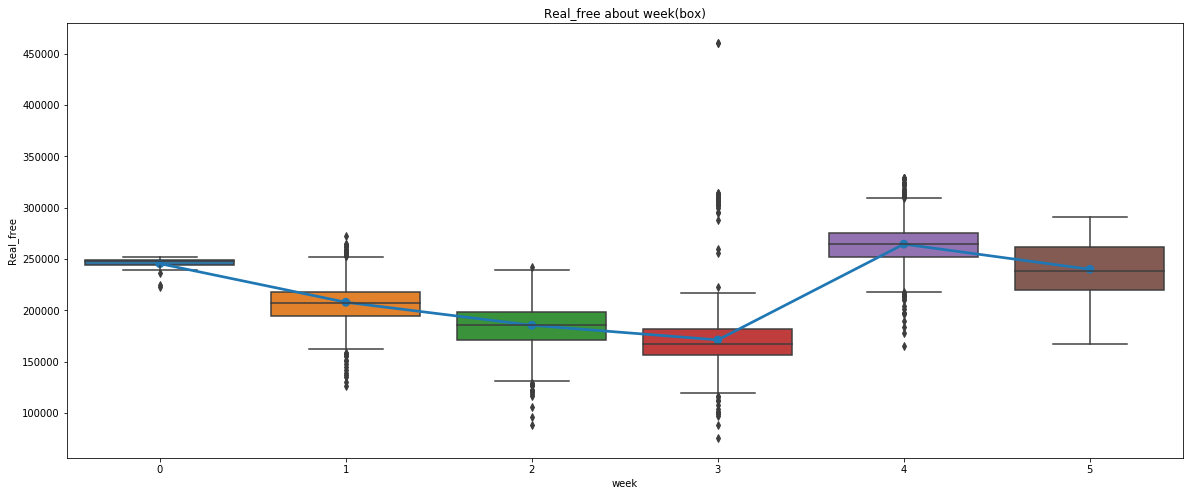

                            OLS Regression Results                            
Dep. Variable:              Real_free   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     2315.
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:35:02   Log-Likelihood:            -1.0463e+05
No. Observations:                8767   AIC:                         2.093e+05
Df Residuals:                    8765   BIC:                         2.093e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.72e+05    906.303    189.742      0.0

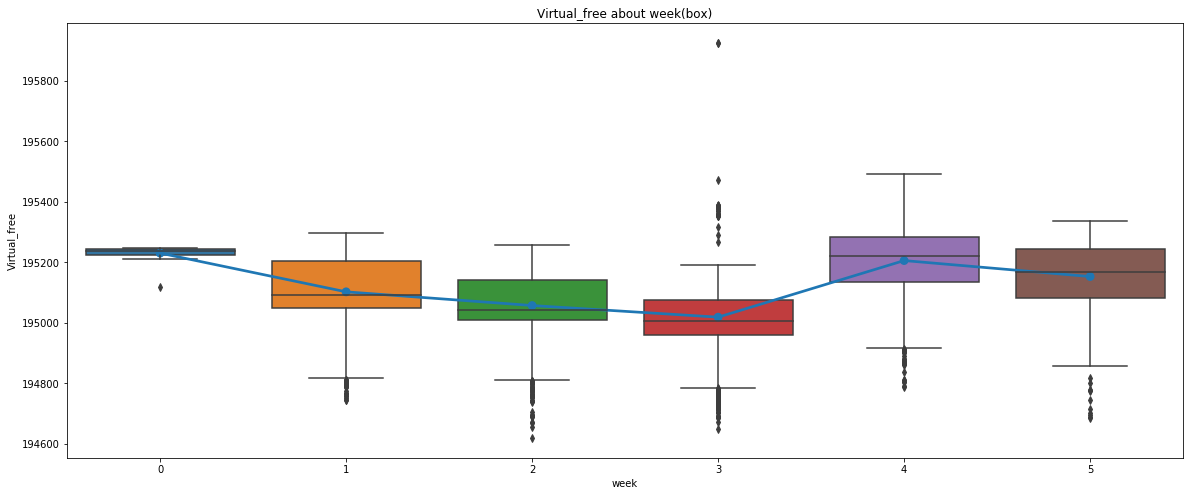

                            OLS Regression Results                            
Dep. Variable:           Virtual_free   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     620.5
Date:                Mon, 21 Sep 2020   Prob (F-statistic):          2.19e-132
Time:                        13:35:02   Log-Likelihood:                -54582.
No. Observations:                8767   AIC:                         1.092e+05
Df Residuals:                    8765   BIC:                         1.092e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.95e+05      3.007   6.49e+04      0.0

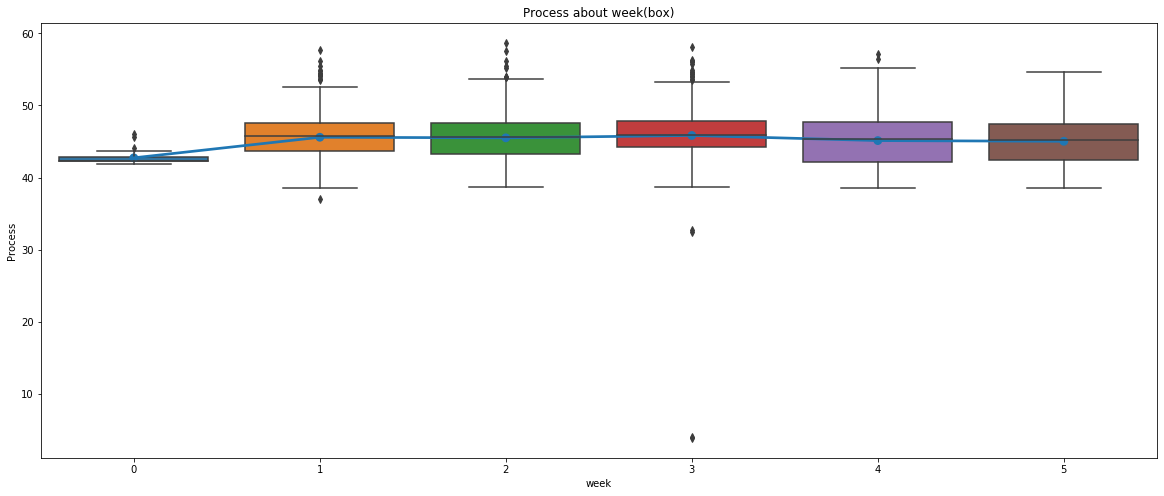

                            OLS Regression Results                            
Dep. Variable:                Process   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     24.22
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           8.74e-07
Time:                        13:35:03   Log-Likelihood:                -21732.
No. Observations:                8767   AIC:                         4.347e+04
Df Residuals:                    8765   BIC:                         4.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.7684      0.071    645.255      0.0

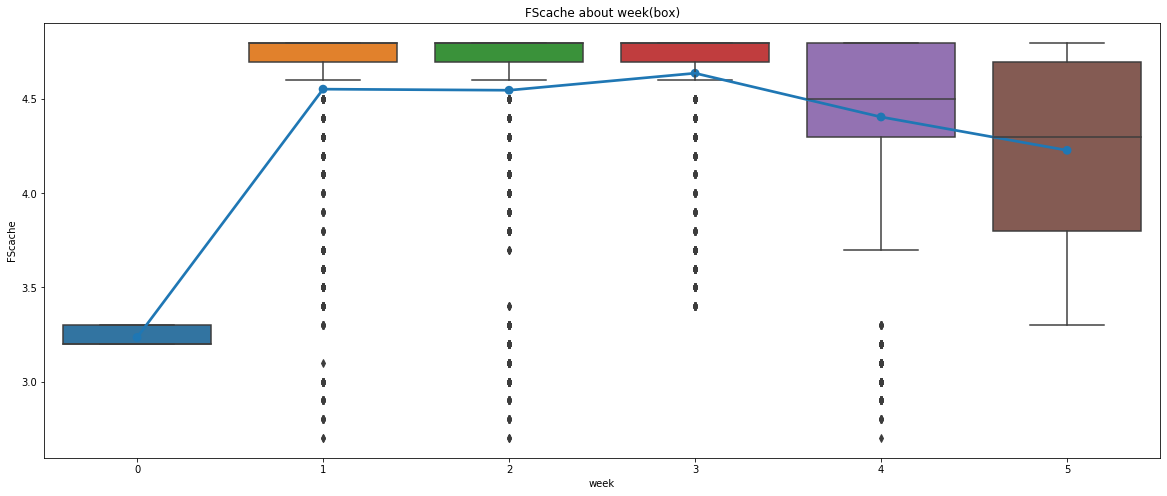

                            OLS Regression Results                            
Dep. Variable:                FScache   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     201.3
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           3.48e-45
Time:                        13:35:03   Log-Likelihood:                -5853.9
No. Observations:                8767   AIC:                         1.171e+04
Df Residuals:                    8765   BIC:                         1.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6476      0.012    400.827      0.0

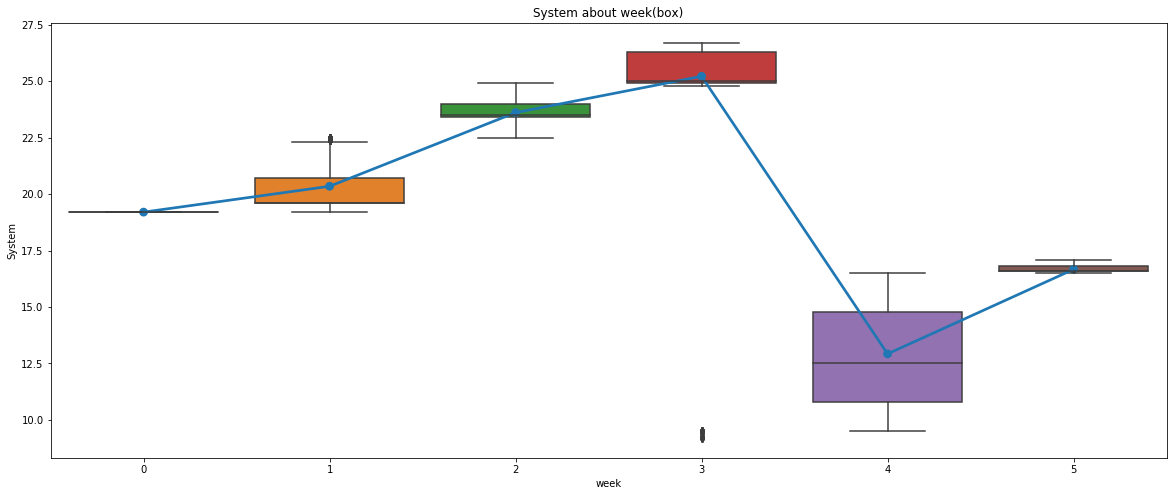

                            OLS Regression Results                            
Dep. Variable:                 System   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     2979.
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:35:03   Log-Likelihood:                -25082.
No. Observations:                8767   AIC:                         5.017e+04
Df Residuals:                    8765   BIC:                         5.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.1701      0.104    242.156      0.0

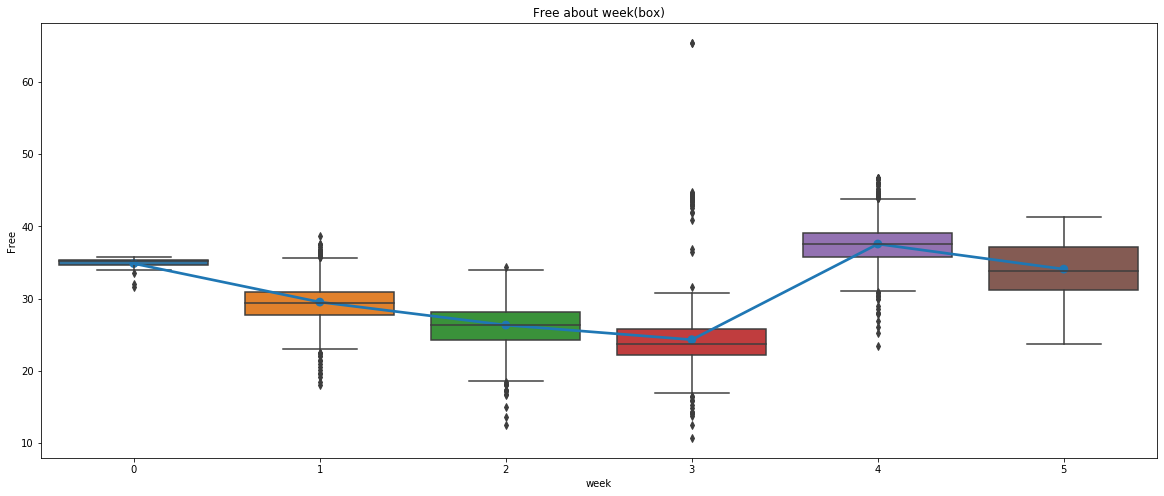

                            OLS Regression Results                            
Dep. Variable:                   Free   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     2315.
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:35:04   Log-Likelihood:                -26952.
No. Observations:                8767   AIC:                         5.391e+04
Df Residuals:                    8765   BIC:                         5.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.4074      0.129    189.715      0.0

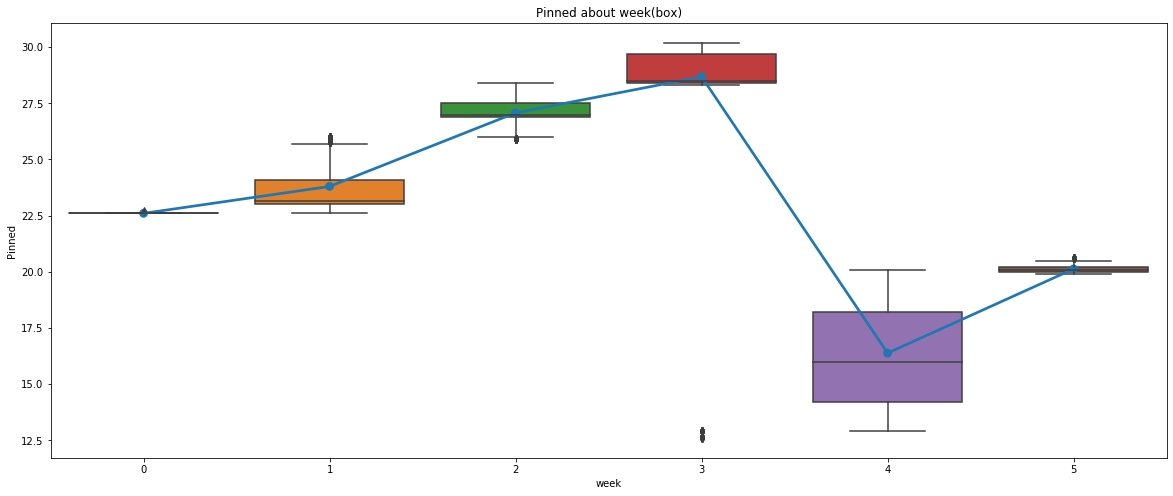

                            OLS Regression Results                            
Dep. Variable:                 Pinned   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     2969.
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:35:04   Log-Likelihood:                -25097.
No. Observations:                8767   AIC:                         5.020e+04
Df Residuals:                    8765   BIC:                         5.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.6339      0.104    275.024      0.0

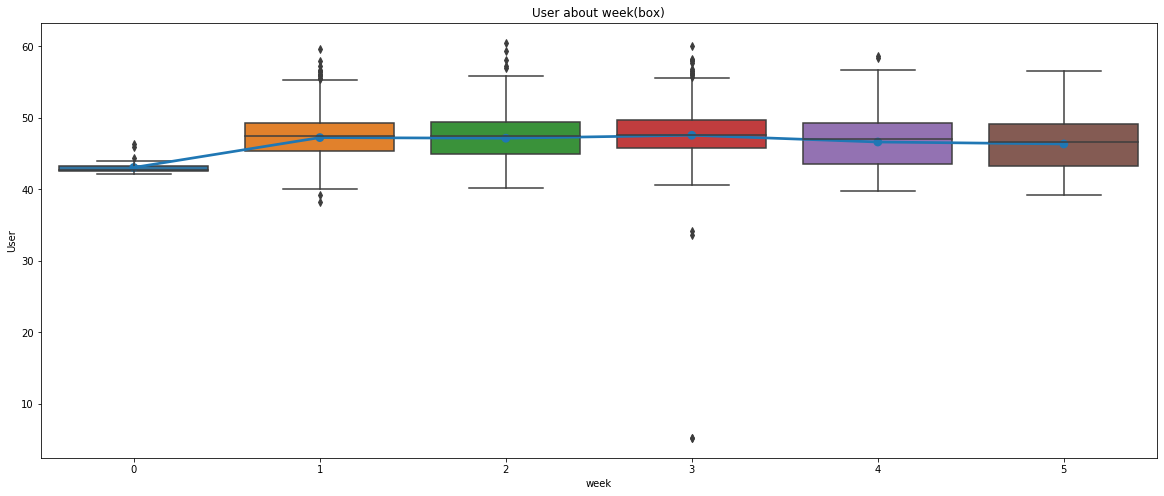

                            OLS Regression Results                            
Dep. Variable:                   User   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           1.10e-11
Time:                        13:35:04   Log-Likelihood:                -22342.
No. Observations:                8767   AIC:                         4.469e+04
Df Residuals:                    8765   BIC:                         4.470e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.4961      0.076    624.596      0.0

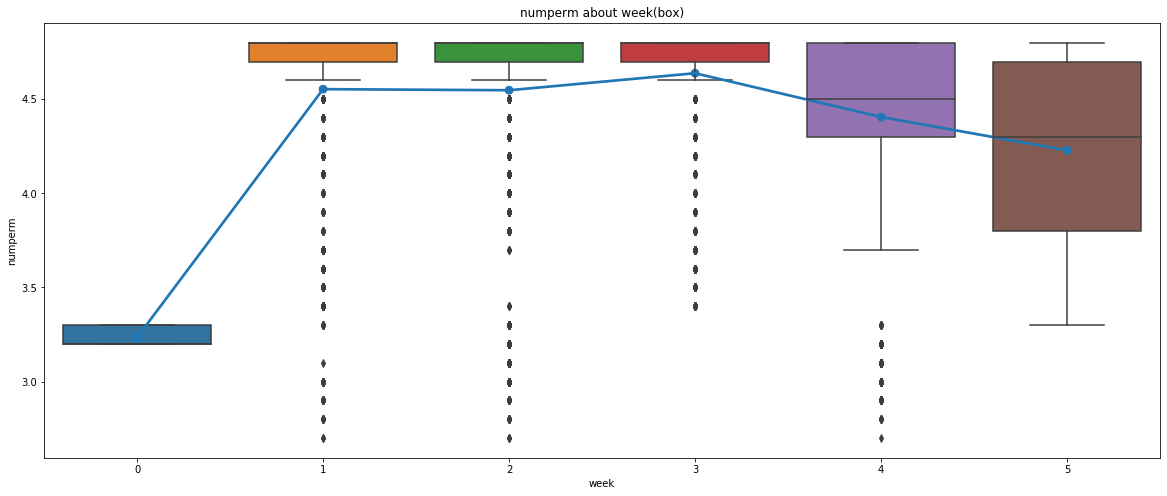

                            OLS Regression Results                            
Dep. Variable:                numperm   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     201.3
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           3.48e-45
Time:                        13:35:05   Log-Likelihood:                -5853.9
No. Observations:                8767   AIC:                         1.171e+04
Df Residuals:                    8765   BIC:                         1.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6476      0.012    400.827      0.0

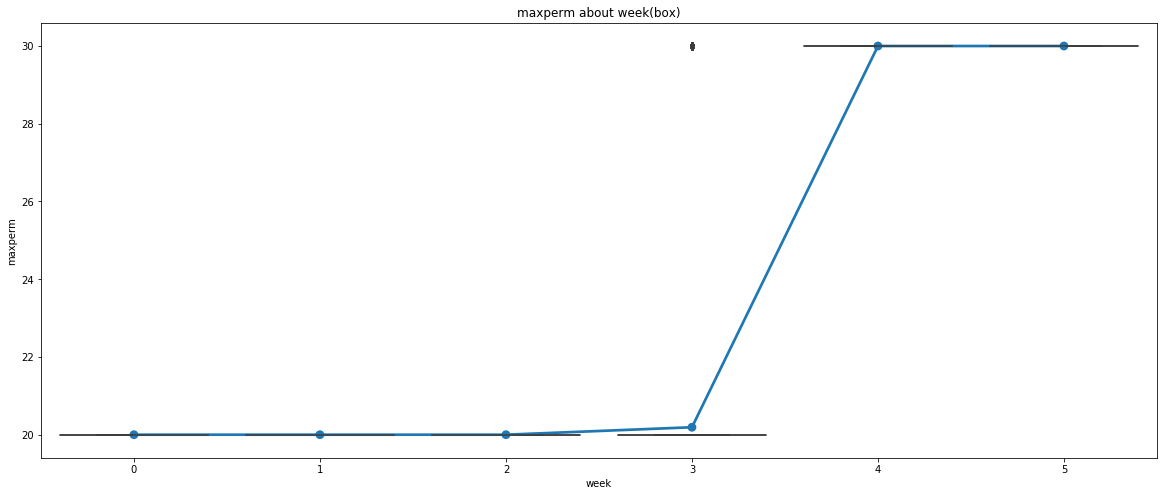

                            OLS Regression Results                            
Dep. Variable:                maxperm   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 2.002e+04
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:35:05   Log-Likelihood:                -20788.
No. Observations:                8767   AIC:                         4.158e+04
Df Residuals:                    8765   BIC:                         4.159e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.1680      0.064    238.147      0.0

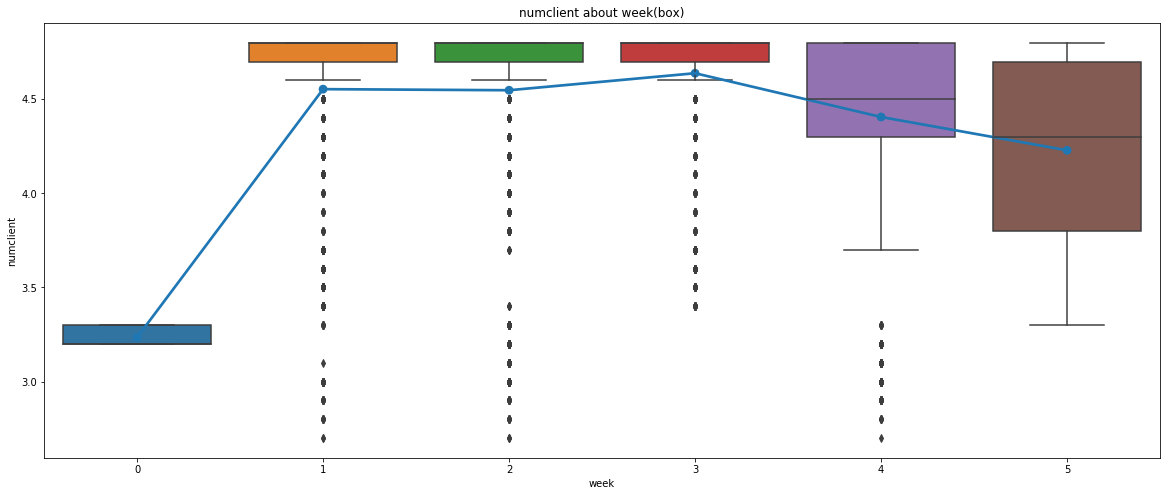

                            OLS Regression Results                            
Dep. Variable:              numclient   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     201.3
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           3.48e-45
Time:                        13:35:05   Log-Likelihood:                -5853.9
No. Observations:                8767   AIC:                         1.171e+04
Df Residuals:                    8765   BIC:                         1.173e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6476      0.012    400.827      0.0

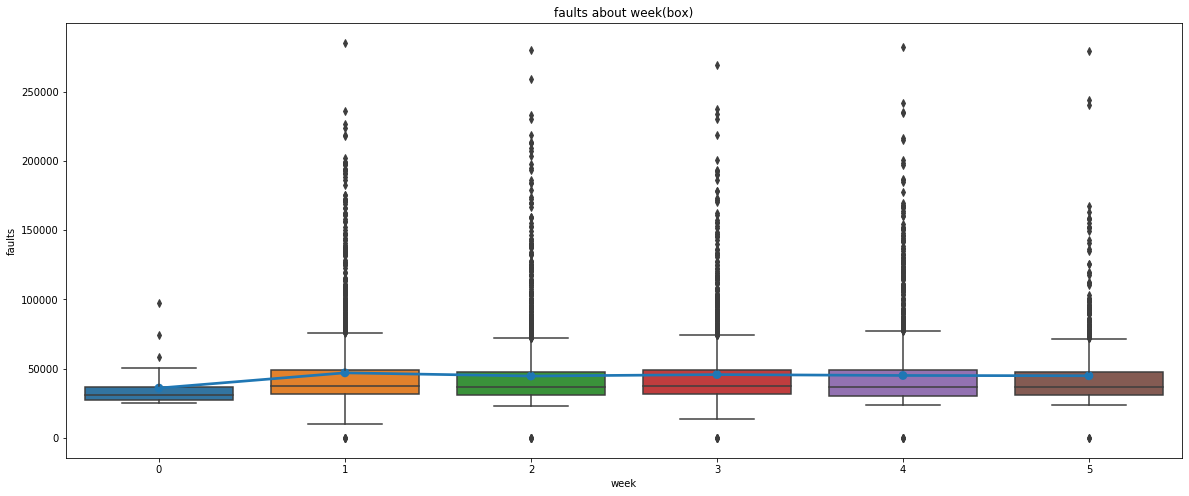

                            OLS Regression Results                            
Dep. Variable:                 faults   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.453
Date:                Mon, 21 Sep 2020   Prob (F-statistic):              0.117
Time:                        13:35:06   Log-Likelihood:            -1.0187e+05
No. Observations:                8767   AIC:                         2.037e+05
Df Residuals:                    8765   BIC:                         2.038e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.649e+04    661.599     70.263      0.0

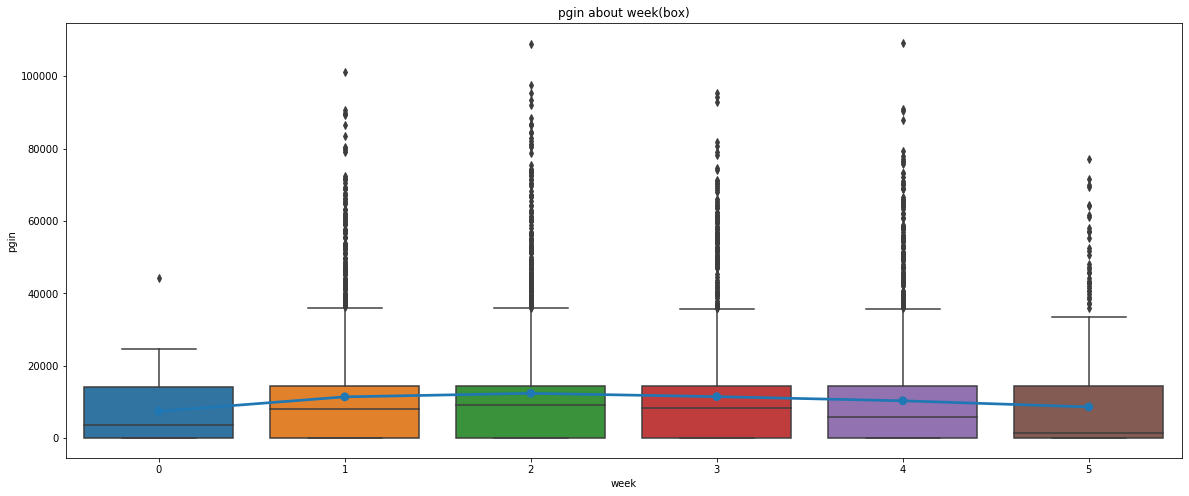

                            OLS Regression Results                            
Dep. Variable:                   pgin   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     25.77
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           3.93e-07
Time:                        13:35:06   Log-Likelihood:                -96521.
No. Observations:                8767   AIC:                         1.930e+05
Df Residuals:                    8765   BIC:                         1.931e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.273e+04    359.489     35.413      0.0

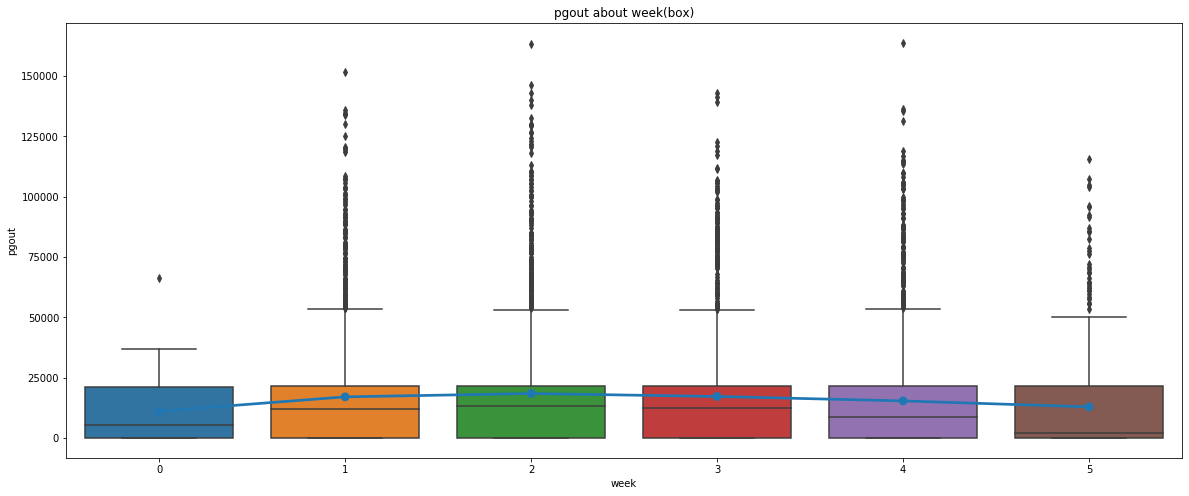

                            OLS Regression Results                            
Dep. Variable:                  pgout   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     25.71
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           4.04e-07
Time:                        13:35:06   Log-Likelihood:            -1.0005e+05
No. Observations:                8767   AIC:                         2.001e+05
Df Residuals:                    8765   BIC:                         2.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.907e+04    537.518     35.473      0.0

In [18]:
for col in new_cols[1:-1]:
    f, ax = plt.subplots(figsize=(20, 8))
    sns.boxplot(x='week', y=col, data=train, ax = ax)
    sns.pointplot(x='week', y=col, data=train.groupby('week', as_index=False)[col].mean())
    plt.title(col + ' about week(box)')
    plt.show()
    results = ols(f'{col}~week', data=train).fit()
    print(results.summary())
    anova_table = sm.stats.anova_lm(results, typ=2)
    print(anova_table)